# In this tutorial, we discuss RDP to DP conversion.


**Renyi Differential Privacy** (and the related **Moments Accountant**) has been the key driving force behind the first practical algorithm for deep learning with differential privacy,  DP-SGD (with per-example gradient clipping).  The key underlying idea is to compose the entire RDP function and only convert to the desired $(\epsilon,\delta)$-DP after running the algorithm for many iterations. Interestingly, the standard conversion rule is not the tightest one can get, which say that there are some mileage one can save from simply doing the math more accurately. 

There are three conversion formula that have been proposed.

**The basic conversion rule** --- Mironov rule --- uses the following formula
$$
\epsilon(\delta) = \min_{\alpha \geq 1} \mathrm{RDP}(\alpha) + \frac{\log(1/\delta)}{\alpha-1}.
$$

**Advanced conversion rule** due to Balle et al. (2019) and Canonne (2020) https://arxiv.org/abs/2004.00010 improves the formula into
$$
\epsilon(\delta) = \min_{\alpha \geq 1} \mathrm{RDP}(\alpha) + \log(\frac{\alpha-1}{\alpha}) +\frac{\log(1/\delta) - \log(\alpha)}{\alpha-1}.
$$

**The optimal conversion rule** is more complex and does not have a closed-form expression. It is conjectured in Balle et al. (2019) https://arxiv.org/abs/1905.09982 then proven by Asoodeh et al (2020) https://arxiv.org/abs/2001.05990 via a different approach.

Autodp implements the optimal conversion by converting each $(\alpha,\mathrm{RDP}(\alpha))$ bound into the tradeoff function,find the resulting $\epsilon$, then numerically minimize the bound over $\alpha \geq 0$.

Notice that it suffices to maximize over $\alpha \geq 0.5$, but the region between $[0.5,1]$ is important for obtaining the optimal RDP to f-DP conversion.

In this notebook we will compare the different ways to convert RDP to DP and to understand the resulting differences.


In [1]:
from autodp.mechanism_zoo import ExactGaussianMechanism, PureDP_Mechanism
from autodp.transformer_zoo import Composition
import matplotlib.pyplot as plt
%matplotlib inline 

## Let's first declare the mechnisms of interest

In [2]:
from autodp.mechanism_zoo import GaussianMechanism, RandresponseMechanism
import numpy as np

eps = 1
sigma = 1.0 / eps
p = np.exp(eps)/(1+np.exp(eps))

gm0 = GaussianMechanism(sigma,name='GM0',approxDP_off=True, use_basic_RDP_to_approxDP_conversion=True)
gm1 = GaussianMechanism(sigma,name='GM1',approxDP_off=True)

gm1b = GaussianMechanism(sigma,name='GM1b',approxDP_off=True, use_fDP_based_RDP_to_approxDP_conversion=True)
gm3 = ExactGaussianMechanism(sigma,name='GM')
rr = RandresponseMechanism(p, name='RandResponse')
rr2 = PureDP_Mechanism(eps,name='RandResponse_as_pureDP')

#label_list = ['GM_optimal_RDP_conversion','GM_exact','RR']
#['GM_optimal_RDP_conversion','GM_exact','RR_optimal_RDP_conversion', 'RR_exact']#, 'GM_naive_RDP_conversion']


##  We first compare the three conversion rules for the simple Gaussian mechanism.

/usr/local/lib/python3.8/site-packages/scipy/optimize/_optimize.py:2782: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
/usr/local/lib/python3.8/site-packages/scipy/optimize/_optimize.py:2322: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


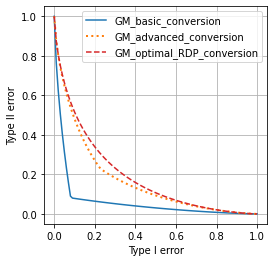

In [3]:
label_list = ['GM_basic_conversion','GM_advanced_conversion','GM_optimal_RDP_conversion']

fpr_list0, fnr_list0 = gm0.plot_fDP()
fpr_list1, fnr_list1 = gm1.plot_fDP()

fpr_list1b, fnr_list1b = gm1b.plot_fDP()
fpr_list3, fnr_list3 = gm3.plot_fDP()
#fpr_list4, fnr_list4 = rr.plot_fDP()
fpr_list5, fnr_list5 = rr2.plot_fDP()

plt.figure(figsize=(4,4))
plt.plot(fpr_list0,fnr_list0)
plt.plot(fpr_list1, fnr_list1,':',linewidth=2)
#plt.plot(fpr_list4, fnr_list4,'-.')
plt.plot(fpr_list1b, fnr_list1b,'--',color='#d62728')
#plt.plot(fpr_list0,fnr_list0,'-.')
#plt.plot(fdp_list1,fnr_list1)
plt.legend(label_list)
plt.xlabel('Type I error')
plt.ylabel('Type II error')
plt.grid()
plt.savefig('rdp2fdp_comparison.pdf')
plt.show()


**Remark**: The results show that for Gaussian mechanism, the advanced formula improves drastically over the naive conversion and that the optimal conversion improves a bit further over the advanced formula.

## How do we know that the optimal conversion really cannot be improved? How does the optimal RDP to DP conversion works comparing to the direct calculation from the Analytical Gaussian Mechanism? 

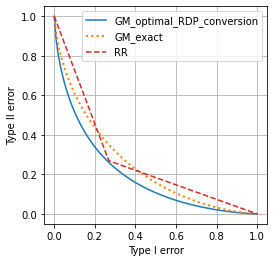

In [4]:
label_list = ['GM_optimal_RDP_conversion','GM_exact','RR']

# fpr_list0, fnr_list0 = gm0.plot_fDP()
# fpr_list1, fnr_list1 = gm1.plot_fDP()

# fpr_list1b, fnr_list1b = gm1b.plot_fDP()
# fpr_list3, fnr_list3 = gm3.plot_fDP()
# #fpr_list4, fnr_list4 = rr.plot_fDP()
# fpr_list5, fnr_list5 = rr2.plot_fDP()

plt.figure(figsize=(4,4))
plt.plot(fpr_list1b,fnr_list1b)
plt.plot(fpr_list3, fnr_list3,':',linewidth=2)
#plt.plot(fpr_list4, fnr_list4,'-.')
plt.plot(fpr_list5, fnr_list5,'--',color='#d62728')
#plt.plot(fpr_list0,fnr_list0,'-.')
#plt.plot(fdp_list1,fnr_list1)

plt.legend(label_list)
plt.xlabel('Type I error')
plt.ylabel('Type II error')
plt.grid()
plt.savefig('rdp2fdp_GM_vs_RR.pdf')
plt.show()

**Remark**: There are two interesting observations we can make here. First, the optimal RDP conversion cannot really be further improved, at least not everywhere. This is because RR satisfies the same RDP bound (see the figure below!), improving the blue curve at the point where blue and red touches results in a contradiction. Second, the exact f-DP of a GM iss strictly stronger than the optimal conversion anywhere. This indicates that if $(\epsilon,\delta)$-DP is needed, it is lossy to go through RDP as an intermediate step.

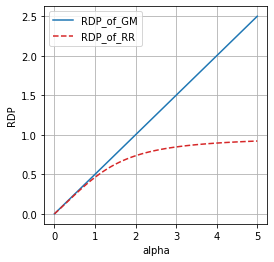

In [5]:
label_list2 = ['RDP_of_GM','RDP_of_RR']#, 'RDP_of_pureDP']  #'exact_RDP_GM',


alpha_list1b, RDP_list1b = gm1b.plot_RDP(alphamax=5, length=101)
#alpha_list3, RDP_list3 = gm3.plot_RDP(alphamax=5,length=101)
alpha_list4, RDP_list4 = rr.plot_RDP(alphamax=5,length=101)
#alpha_list5, RDP_list5 = rr2.plot_RDP(alphamax=5,length=101)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


plt.figure(figsize=(4,4))
plt.plot(alpha_list1b,RDP_list1b)
#plt.plot(alpha_list3, RDP_list3 ,':')
plt.plot(alpha_list4, RDP_list4,'--',color=colors[3])
#plt.plot(alpha_list5, RDP_list5,'--')
plt.legend(label_list2)
plt.xlabel('alpha')
plt.ylabel('RDP')
plt.grid()
plt.savefig('rdp_comparisons.pdf')
plt.show()

## The two observations above can also be seen in $(\epsilon,\delta)$-DP directly.

In [6]:
delta_list = np.linspace(0,0.5,20)
eps_list_gm3 = np.zeros_like(delta_list)
eps_list_gm1b = np.zeros_like(delta_list)
eps_list_rr = np.zeros_like(delta_list)
for i,delta in enumerate(delta_list):
    eps_list_gm1b[i] = gm1b.approxDP(delta)
    eps_list_gm3[i] = gm3.approxDP(delta)
    eps_list_rr[i] = rr.approxDP(delta)
    #print(eps_list_gm3[i],eps_list_rr[i])
    



/usr/local/lib/python3.8/site-packages/scipy/optimize/_optimize.py:2782: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
/usr/local/lib/python3.8/site-packages/scipy/optimize/_optimize.py:2322: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


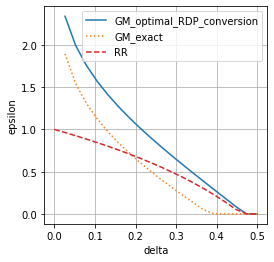

In [7]:
label_list2 = ['GM_optimal_RDP_conversion','GM_exact','RR']
plt.figure(figsize=(4,4))
plt.plot(delta_list,eps_list_gm1b)
#plt.plot(alpha_list3, RDP_list3 ,':')
plt.plot(delta_list,eps_list_gm3,':')
plt.plot(delta_list, eps_list_rr,'--',color=colors[3])
#plt.plot(alpha_list5, RDP_list5,'--')
plt.legend(label_list2)
plt.xlabel('delta')
plt.ylabel('epsilon')
plt.grid()
plt.savefig('dp_comparisons.pdf')
plt.show()


## Finally, in terms of $(\epsilon,\delta)$-DP, how much does the advanced RDP2DP converssion rules improve over the naive conversion rule?

In [8]:
delta_list = np.linspace(0,0.5,20)
eps_list_gm0 = np.zeros_like(delta_list)
eps_list_gm1 = np.zeros_like(delta_list)
eps_list_gm1b = np.zeros_like(delta_list)
for i,delta in enumerate(delta_list):
    eps_list_gm0[i] = gm0.approxDP(delta)
    eps_list_gm1[i] = gm1.approxDP(delta)
    eps_list_gm1b[i] = gm1b.approxDP(delta)
    #print(eps_list_gm3[i],eps_list_rr[i])

/usr/local/lib/python3.8/site-packages/scipy/optimize/_optimize.py:2782: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
/usr/local/lib/python3.8/site-packages/scipy/optimize/_optimize.py:2322: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


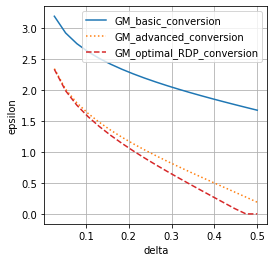

In [9]:
label_list = ['GM_basic_conversion','GM_advanced_conversion','GM_optimal_RDP_conversion']
plt.figure(figsize=(4,4))
plt.plot(delta_list,eps_list_gm0)
#plt.plot(alpha_list3, RDP_list3 ,':')
plt.plot(delta_list,eps_list_gm1,':')
plt.plot(delta_list, eps_list_gm1b,'--',color=colors[3])
#plt.plot(alpha_list5, RDP_list5,'--')
plt.legend(label_list)
plt.xlabel('delta')
plt.ylabel('epsilon')
plt.grid()
plt.savefig('dp_comparisons_conversion_rules.pdf')
plt.show()


**Remark**: We observe that the improvement from the basic conversion is pretty significant. The improvement from advanced to optimal RDP conversion becomes significant mostly for larger $\delta$ (or smaller $\epsilon$s).

## How about for smaller $\delta$? Let's plot it in log-scale
(This may take a while for the complex numerical computation)

In [10]:
delta_list = 10.0**np.array(-np.linspace(0,6,20))
eps_list_gm0 = np.zeros_like(delta_list)
eps_list_gm1 = np.zeros_like(delta_list)
eps_list_gm1b = np.zeros_like(delta_list)
for i,delta in enumerate(delta_list):
    eps_list_gm0[i] = gm0.approxDP(delta)
    eps_list_gm1[i] = gm1.approxDP(delta)
    eps_list_gm1b[i] = gm1b.approxDP(delta)
    


/usr/local/lib/python3.8/site-packages/scipy/optimize/_optimize.py:2322: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/usr/local/lib/python3.8/site-packages/scipy/optimize/_optimize.py:2782: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom


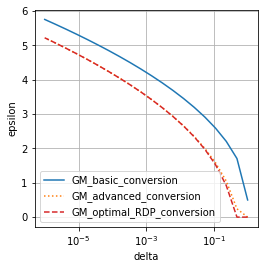

In [11]:
label_list = ['GM_basic_conversion','GM_advanced_conversion','GM_optimal_RDP_conversion']
plt.figure(figsize=(4,4))
plt.plot(delta_list,eps_list_gm0)
#plt.plot(alpha_list3, RDP_list3 ,':')
plt.plot(delta_list,eps_list_gm1,':')
plt.plot(delta_list, eps_list_gm1b,'--',color=colors[3])
#plt.plot(alpha_list5, RDP_list5,'--')
plt.xscale('log')
plt.legend(label_list)
plt.xlabel('delta')
plt.ylabel('epsilon')
plt.grid()
plt.savefig('dp_comparisons_conversion_rules_log.pdf')
plt.show()

**Remark**: This concludes that the improvements from advanced to the optimal conversion is mostly prominent for the small $\epsilon$ (or large $\delta$) regime. For this reason, by default, autodp opts for the simpler advanced conversion (while leaving the optimal conversion an option for advanced users).